I worked on analyzing political affiliations based on plain text, which is pretty similar to judging whether given article is part of fake news or not. The maion objective behind this exercise was to generate some sort of labelled data to train any ML model with.
Fake News detection is a hard problem and it becomes harder if you don't have a region specific fakenews dataset. In this post we try to findout the groups or communities using their twitter characteristics like retweets and mentions and constructing a network out of it. I analyze the results I get and will try to makesome sense of the data we have
# Gathering Data
The main task in our case is gathering data, I do so by writing a MultiThreaded Tweet crawler which helped me crawl roughly 50 million tweets in roughly 5 days. You can check out the repository yourself and do some crawlingn for fun. The data was stored in a postgresql database which was also primary dump for all related data I got.
## Software Used
I used my [HomeLab](https://bagdeabhishek.github.io/homelab/) to crawl all this data.
1. The first thing you need to do is setup PostGreSQL on your compunter which you'll use for keeping crawled data. There are two settings you should be careful about while configuring the service. First, move the data directory to the disk you'll use for storage. Postgres by default stores the data in /var directory which can be a problem if you have your root partition on a small capacity SSD. The second thing is, make sure you are able to access over network. It becomes way easier to work with the data on yourt local system using an IDE like DataGrip
2. The second thing is writing a Twitter Crawler, I use the official API along with Tweepy library to crawl data. I've made the code generic enough so taht anyone can download it and run using a simple configuration file. You can clone [this](https://github.com/bagdeabhishek/TweetCrawlMultiThreaded) repository and edit the configuration file. You can add the handles you want to crawl in the handles.txt file. You can update the handles needed to crawl in the next layer using the -r option.
3. It would making working with data infinitely easier if you process data on the server itself. To do this there is no better tool than Jupyter Notebooks and Jupyter Lab offers same features with many additonal features. You can install it easily using pip. Once you install it, change some parameters in the confifuration file and you are ready to access over the internet.
4. For inserting the data in potgres database you'll need a python library. Psycopg2 is the most supported library out there and it's very easy to use

Once everything is set up correctly, you can launch the TweetCrawler.py file and it will happy chug along crawling twitter handles and storing it in database. One 'bug' is that some of the columns will have curl;y braces in it. This is mostly due to Psycopg2 library inserts data in database. You can clean the data using the following SQL command
```sql
UPDATE tweets_cleaned as t set retweeted_status_url =  TRANSLATE (t.retweeted_status_url,'{}','' );
```
Once done create indexes on the 'tweet_from' columns to make retrieving and working on the crawled data a bit easier. You can run the following SQL commmand to do that
```sql
CREATE INDEX on tweet_cleaned(id);
```
After these steps you should have data to work with, we will now work on the data we have to 
# Operating on data
The data I've crawled is huge and there is no way to work on it in memory (even after upgrading my main memory to 32gigs). So pandas is out of question. Pandas loads all the data in memory and then performs operations on it, our data size requires us to use more sophisticated solutions which generally are used in case of big data. 

## Apache spark
Apache spark has a very good dataframe API which can acutally speed up data access and processing. Though it is generally discouraged to use a single node apache spark cluster, I found the advantage of operating directly on data using DF API is significantly greater than loading data in memory and then working on it(which is anyways impossible due to amount of data we have). 

Setting up apache spark is fairly straightforward. Complete the setup add the postgres jdbc jar file in the appropriate location and you are good to go. Installing the pyspark package using will make things easier to work with if you prefer python instead of scala like me. The main issue I encountered is that, since the table I'm operating on is a single table with 50 millon rows. There is no parallelism present for the spark to take advantage of which caused ridiculously wait times. Initially these wait times caused a lot of timeouts and changing the settings fixed that. Still the time taken is ridiculous. 

To fix this problem I searched for ways to partition the table. Postgres allows you to partition the table using inheritance but in our case the table already exists and there is no easy way to partition table once created. The other option is using [pg\_partman](https://github.com/pgpartman/pg_partman). I'll configure the existing tables based on created\_at column so that the database is partitioned based on time intervals. This would ideally allow parallel access to the records and should speed up spark access.

# Plotting the network
Processing the crawled data in a user interactable form becomes challenging with the scale of data I had. The idea I had was to identify clusters in the twitter network and then do further processing on this information.

## Twitter network graph
Constructing the twitter network was done with the NetworkX graphing library in python. I converted the crawled data into list of tuples with one source and one destination node. I kept only the tweets which were retweets for this analysis. In general retweets are a stronger measure of endorsement compared to mentions. I've also observed that the more popular personalities' mentions carry more importance, these personalities rarely retweet. I might scale the edge weights in future keeping this creiteria in mind and do additional processing to get better clutering using gephi's clustering algorithm.

The function to costruct the graph is pretty simple. The graph we construct is a Directed graph where edge weight is the number of times a user A retweets user B. The python function below does the same simple operation and gives a Directed Graph G.
```python
def create_graph(ls_tup):
    G = nx.DiGraph()
    for dc in ls_tup:
        tfrom=dc['tweet_from']
        rt = dc['retweeted_status_user_handle']
        if G.has_edge(tfrom,rt):
            print(tfrom,rt,G[tfrom][rt]['weight'])
            G[tfrom][rt]['weight'] += 1
        else:
            G.add_edge(tfrom,rt,weight=1)
    return(G)
```
We can do a lot of preprocessing in python itself but i've found [Gephi](https://gephi.org/) to be a much better tool which is easier to use and operate on such large amounts of data. The visualizations are also way more engaging and it comes with various plugins to export the network in various formats. 
You can export this Graph easily using GEXF format which can be done using NetworkX library's _write\_gexf()_ function


## Gephi processing
Once you get the GEXF file you can run Gephi and import the data into the tool. Before you do that though, make sure you have installed Oracle's Java version. The difference between Oracle Java and the OpenJDK version is day and night, Gephi basically becomes unusable if the network is as large as I had. Once installed disable the anti-aliasing in settings to make the renders quicker as well.
### Pre-processing
Once you get the data into Gephi you can do some preprocessing, I did the following thigs to weed out un-important nodes

1. Calculate the weighted degrees of all the nodes. Trim the nodes with weighted degrees less than 2 (you can adjust this threhold to much higher)
2. Run the modularity algorithm tweaking the parameters to get less number of communities. You can now see major clusters that aris out of data. 
3. Trim out the clusters with less than say 500 nodes in them. This can be done using the partition count filter in Gephi.
4. Run the clustering algorithm once again on this reduced graph. Now you shoulds see the clusters clear enough. In my case all handles from a particular political party were in a cluster.

### Visualization
Once you have the data the next step is visualizing the data. If you don't want to visualize, go to data tab and select columns of interest in my case that would be the modularity class and export it as CSV or some other format. Visualization in Gephi is pretty cnofusing if you are new to it. For most of the purposes aimply running the Openord clustering algorithm will suffice. That's what I did, I tweaked the phases of Openord algorithm to give more time to expansion phase. Also increasing iterations will help in case of large networks, though it might take more time depending on the hardware you have. 

Once you are happy with the visualization render it and export it in any format you want. Hot-tip you can use the plugin (will add later) which wil generate the HTML code which renders using Javascript for browser friendly interactive rendering.

# Using the data to extract relevant information
Once you have the clustering information you need to filter out tweets according to the clusters you have identified, the first step is now to get this clustering data out of gephi. Getting this data out becomes easier if you export the data directly using CSV file. The following steps are what I followed 
1. After runnning the clustering algorihtm i.e getting the modularity classes. Apply the partition count filter and filter by modularity class. Keep only the classes with more than some threshold amount of nodes in it. This will reduce the number of irrelevant communities.
2. Go to the data tab and select the export as spreadsheet option. In the dialogue box only select the id and modularity class columns and save the file.
3. Create a separate table which will store this mapping from twitter handle to modularity class mapping. You can use create a simple table in postgres which will have two columns one for twitter_handles and the other will store the modularity class. Copying the CSV data into the table can be done simply by using the following command. Keep in mind that you'll have to manually remove the heading column if your modularity_class column is of a different datatype like a BIGINT.
```SQL 
COPY cluster_mapping FROM '/path/to/csv/clusters.csv' WITH (FORMAT csv);
```
4. To actually retrieve valuable information like (text,cluster_id) tuples, we'll need to do retrieve data using SQL JOIN statements. If you have lots of data this JOIN operation becomes basically impossible if you dont have indexes. So we create index on the twitter_handles column of the new table, we already had created index on the table that has all the tweets. 

5. As the number of columns in our case are large it becomes tedious to write the complex SQL statements everytime with joins and stuff. To make our life more convenient we store these complex queries as VIEWS, once we do that the complex SQL query given below becomes the familiar __Select * from view_on_db;__. To create view you just have to prepend "create view non_text_cleaned as " to the below SQL statement

5. Getting this data into Python is tricky, since my dataset of tweets was very large I decided to upgrade my System Memory to 32 GB. The other more saner way is to use Apache Spark as I've noted above. You can still use pandas in python to load using chunking. I read this data into a jupyter noteboook using psycopg2, this was mainly possible because of RAM upgrade. Running the following SQL statement will fetch the relevant data into a python list. I use INNER join becuase I don't want any data which doesn't lie in the selected Modularity classes.
```SQL
SELECT t.tweet_from,t.user_mentions_name,t.retweeted_status_user_handle,c.cluster,c.weighted_degree FROM tweets_cleaned AS t INNER JOIN cluster_mapping AS c ON t.tweet_from = c.id ;
```
6. Load this data into a pandas dataframe using a simple command 
```Python
df = pd.DataFrame(ls ,columns = ["handle","mentions","retweets","cluster","importance"])
```
7. One trick I use is store the relevant dataframe using pickle, this reduces the time to get data from database.



In [38]:
from collections import Counter
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
def __custom_words_accumulator(series,limit=None):
    c = Counter()
    for sentence in series:
        if sentence:
            sent_list = sentence.split(",")
            c.update(sent_list)
    return c.most_common() if not limit else c.most_common(limit)

def split_list(series,handleBool=True):
    handles = []
    listNoOfX = []
    for groupList in series:
        for handle,x in groupList:
            handles.append(handle)
            listNoOfX.append(x)
    if handleBool :
        return(handles)
    else:
        return(listNoOfX)
        


def get_barcharts(df,column_name="retweets"):
    wf = df.groupby("cluster")[column_name].apply(__custom_words_accumulator,limit=50).reset_index()
    wf2 = pd.DataFrame({
    'cluster_id' : np.repeat(wf['cluster'],50),
    'handle': split_list(wf[column_name]),
    'noOfX': split_list(wf[column_name],handleBool=False)
    })
    clusters = wf2.cluster_id.unique()
    sns.set(rc={'figure.figsize': (40,10)})
    i = 0
    f, ax = plt.subplots(len(clusters), 1, figsize=(40, 100))
    f.tight_layout(pad=6.0)
    for cid in clusters:
        g = sns.barplot(x="handle", y="noOfX", hue="cluster_id", data=wf2[wf2.cluster_id==cid],ax=ax[i])
        g.set_xticklabels(g.get_xticklabels(), rotation=50, horizontalalignment='right')
        i+=1    
        
def plot_word_cloud(word_freq_dict,background_color="white", width=800, height=1000,max_words=300, figsize=(50, 50)):
    """
    Display the Word Cloud using Matplotlib
    :param word_freq_dict: Dictionary of word frequencies
    :type word_freq_dict: Dict
    :return: None
    :rtype: None
    """
    word_cloud = WordCloud(background_color=background_color, width=width, height=height,
                           max_words=max_words).generate_from_frequencies(frequencies=word_freq_dict)
    plt.figure(figsize=figsize)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Now that everything is setup we can begin with analysing the data we have. I've started with basic analysis using just Pandas to get a good idea about the process. We start by analysing the clusters we have generated. The clusters make sense only if all the handles speak on a particular topic.
With some data wrangling in python using Pandas I've managed to plot the top 50 handles in each cluster and plot a bar chart. If you see the Image generated below you can see the clusters clearly correspond the users who speak or are interested in simlar areas. 

In [3]:
df = pd.read_pickle("mention_retweet_hastags.pkl")
# get_barcharts(df,"mentions")

I've plotted the mentions in each cluster in the chart above. Why did I choose mentions instead of hashtags or retweets? One important reason was disassociation from the clustering process used in gephi and this analysis. We have already constructed the graph using retweets, if we again use retweets to see if the clusters generated are homogenous or not, we wont' be getting any new information. Looking at the chart we can see that the clusters below have users from a specific group of similar minded individuals. Below I discuss the characteristics about each cluster.

# Clusters
0. If you see the first bar graph. you can see the top 5 handles mentioned are 
    * narendramodi 450447
    * BJP4India 166741
    * AmitShah 152910
    * PMOIndia 84858
    * ArvindKejriwal 67572
   
   These handles clearly correspond to the Bhartiya Janata Party and we will treat this cluster as Pro-BJP. Arvind kejriwal is the clear outlier here but the period around which the tweets were crawled was the time when campaigning for Delhi Elections was in full swing. We can see that many twitter handles from this Pro-BJP cluster we're mentioning Arvind Kejriwal as his party was the prime opposition of BJP in delhi. If we look at other handles in this cluster from the bar graph we can clearly see the pro-BJP community being represented. 
    This also gives a very good example why we cannot use the mentions in a twitter status as endorsements. If the graph we constructed earlier was based on mentions instead of retweets, Arvind kejriwal could've easily been part of the Pro-BJP cluster. 
1. This cluster is a bit harder to identify. It contains handles from Indian National Congress as well as the Aam Aadmi party which are major oppostions parties to the BJP. It also includes troll accounts and memers like ROFLgandhi which are very popular amongst critics of the current governmen. One more important thing to notice here is the number of mentions. The difference between the most mentioned users in this cluster and the pro BJP cluster is drastic. NarendraModi is mentioned 450447 times which when compared to the most mentioned user in this cluster (Arvind Kejriwal, with 84260 mentions) is almost 5 times. The popularity of this cluster seems to be pretty low compared to the Pro-BJP cluster. I wanted to call this cluster pro-Congress cluster but the high presence of AAP handles in the top 50 makes it impossible. This can be explained easily as the time period of gathering data coincided heavily with Delhi Elections
3. This cluster mostly has Sports related channels like espn etc. The sports handles seem majorly from North america, as can the sports in this cluster
6. This cluster contains handles from bollywood actors and hindi TV series.
8. This cluster is hard to identify because the handles do not form a homogenous group.
14. This cluster corresponds to users who are supporters of the Republican party in USA. But on second thought this cluster also includes Pro-Brexit politicians from UK. The common thread that ties this cluster together seems to be that users in this cluster identify with the political right. There are handles from the left as well but going by the stats we can safely assune these are due to users from the cluster criticizing them. 
33. This cluster has users who talk about film actors and actresses who prominently work in the film industry in Southern India
34. This cluster has handles from popular football clubs around the world. We can assume the users in the cluster mostly talk or are interested in football
35. This cluster has handles which are from Pakistan. The top handles are some of the major politicians from Pakistan.
43. This cluster mostly corresponds to the US Presdential election to happen in 2020. The top handles in this cluster are some of the top contenders from the Democratic and Republican Party
44. People in this cluster are involved in UK politics as can be seen from the top handles. This cluster also has a lot News channels which are UK specific
47. This cluster has handles which are associated with the United Nations and its sub-organizations
48. Most of the handles mentioned in this cluster are related to Australia and the news agencies there.
66. The top handles in this cluster are prominent mexican personalities across multiple areas
67. This cluster has handles from Spain and handles from madrid feature prominently in the top handles.
73. Handles here are from canada. Politicians and sports teams are among the top handles here. 
87. These handles include mostly artists and illustrators who primarily sketch cartoons. Channels which show cartoons like cartoon network and nickleodeon also feature at the top
91. This cluster has handles from software industry as well as Technology related handles.

Going by the constituents of the cluster only clusters 0 and 1 seem to be of interest. I must clarify though that this is only because I wanted to do this analysis in the Indian context. If we look closely the clusters - and - are also pretty interesting. The clubbing of right wing politicians across two seperate countries i.e UK and USA seems to suggest that the underlying users are more aligned with political ideology rather than any single political party. Does this also mean that the Indian rightwing is substantially different from the global definition of right wing? This aspect can be studied further with more focus on analysing the characteristics of the tweets and users in these clusters.

Now that we have finalized the clusters let's look at the aggregate statistics of each cluster 

In [31]:
grouped_df = df[df.cluster.isin([0,1,87])].groupby("cluster")
filtered_clusters = grouped_df.describe()
filtered_clusters

importance                                                        \
             count         mean          std  min    25%     50%     75%   
cluster                                                                    
0        7560434.0  1438.196892  3765.737962  2.0  435.0  1159.0  2002.0   
1        3766568.0  1172.973474  1330.962340  2.0  358.0   960.0  1722.0   
87        634909.0   500.311903   435.519416  2.0  151.0   346.0   785.0   

                   
              max  
cluster            
0        147132.0  
1         24979.0  
87         2155.0

If we see the number of tweets from each cluster we can see that the cluster 0(which is mostly ProBJP cluster) is almost double the size of the cluster 1 (which has AAP and Congress supporters). The importance column here is the weighted degree from the network graph we constructed before, vaguely speaking it represents the importance of any node in the graph. If you check the mean importance both the cluster are pretty close. The 50% column here corresponds to the 50 percentile here which is the same as median. The median values between these two clusters are also pretty close which when interpreted along with 75 percentile value tells us that these clusters have handles which are fairly similar in importance in the network graph. For contrast, if we see the cluster 87, the 25, 50 and 75 percentile scores are very different from the first two clusters. This tells us that the cluster 87 has nodes which are not that important in the graph. 

Now that we have the clusters of interest narrowed down we can dig further to anylyse the hashtags from each cluster to get a better idea

In [40]:
hashtags_df = grouped_df["hashtags"].apply(__custom_words_accumulator,limit=200)


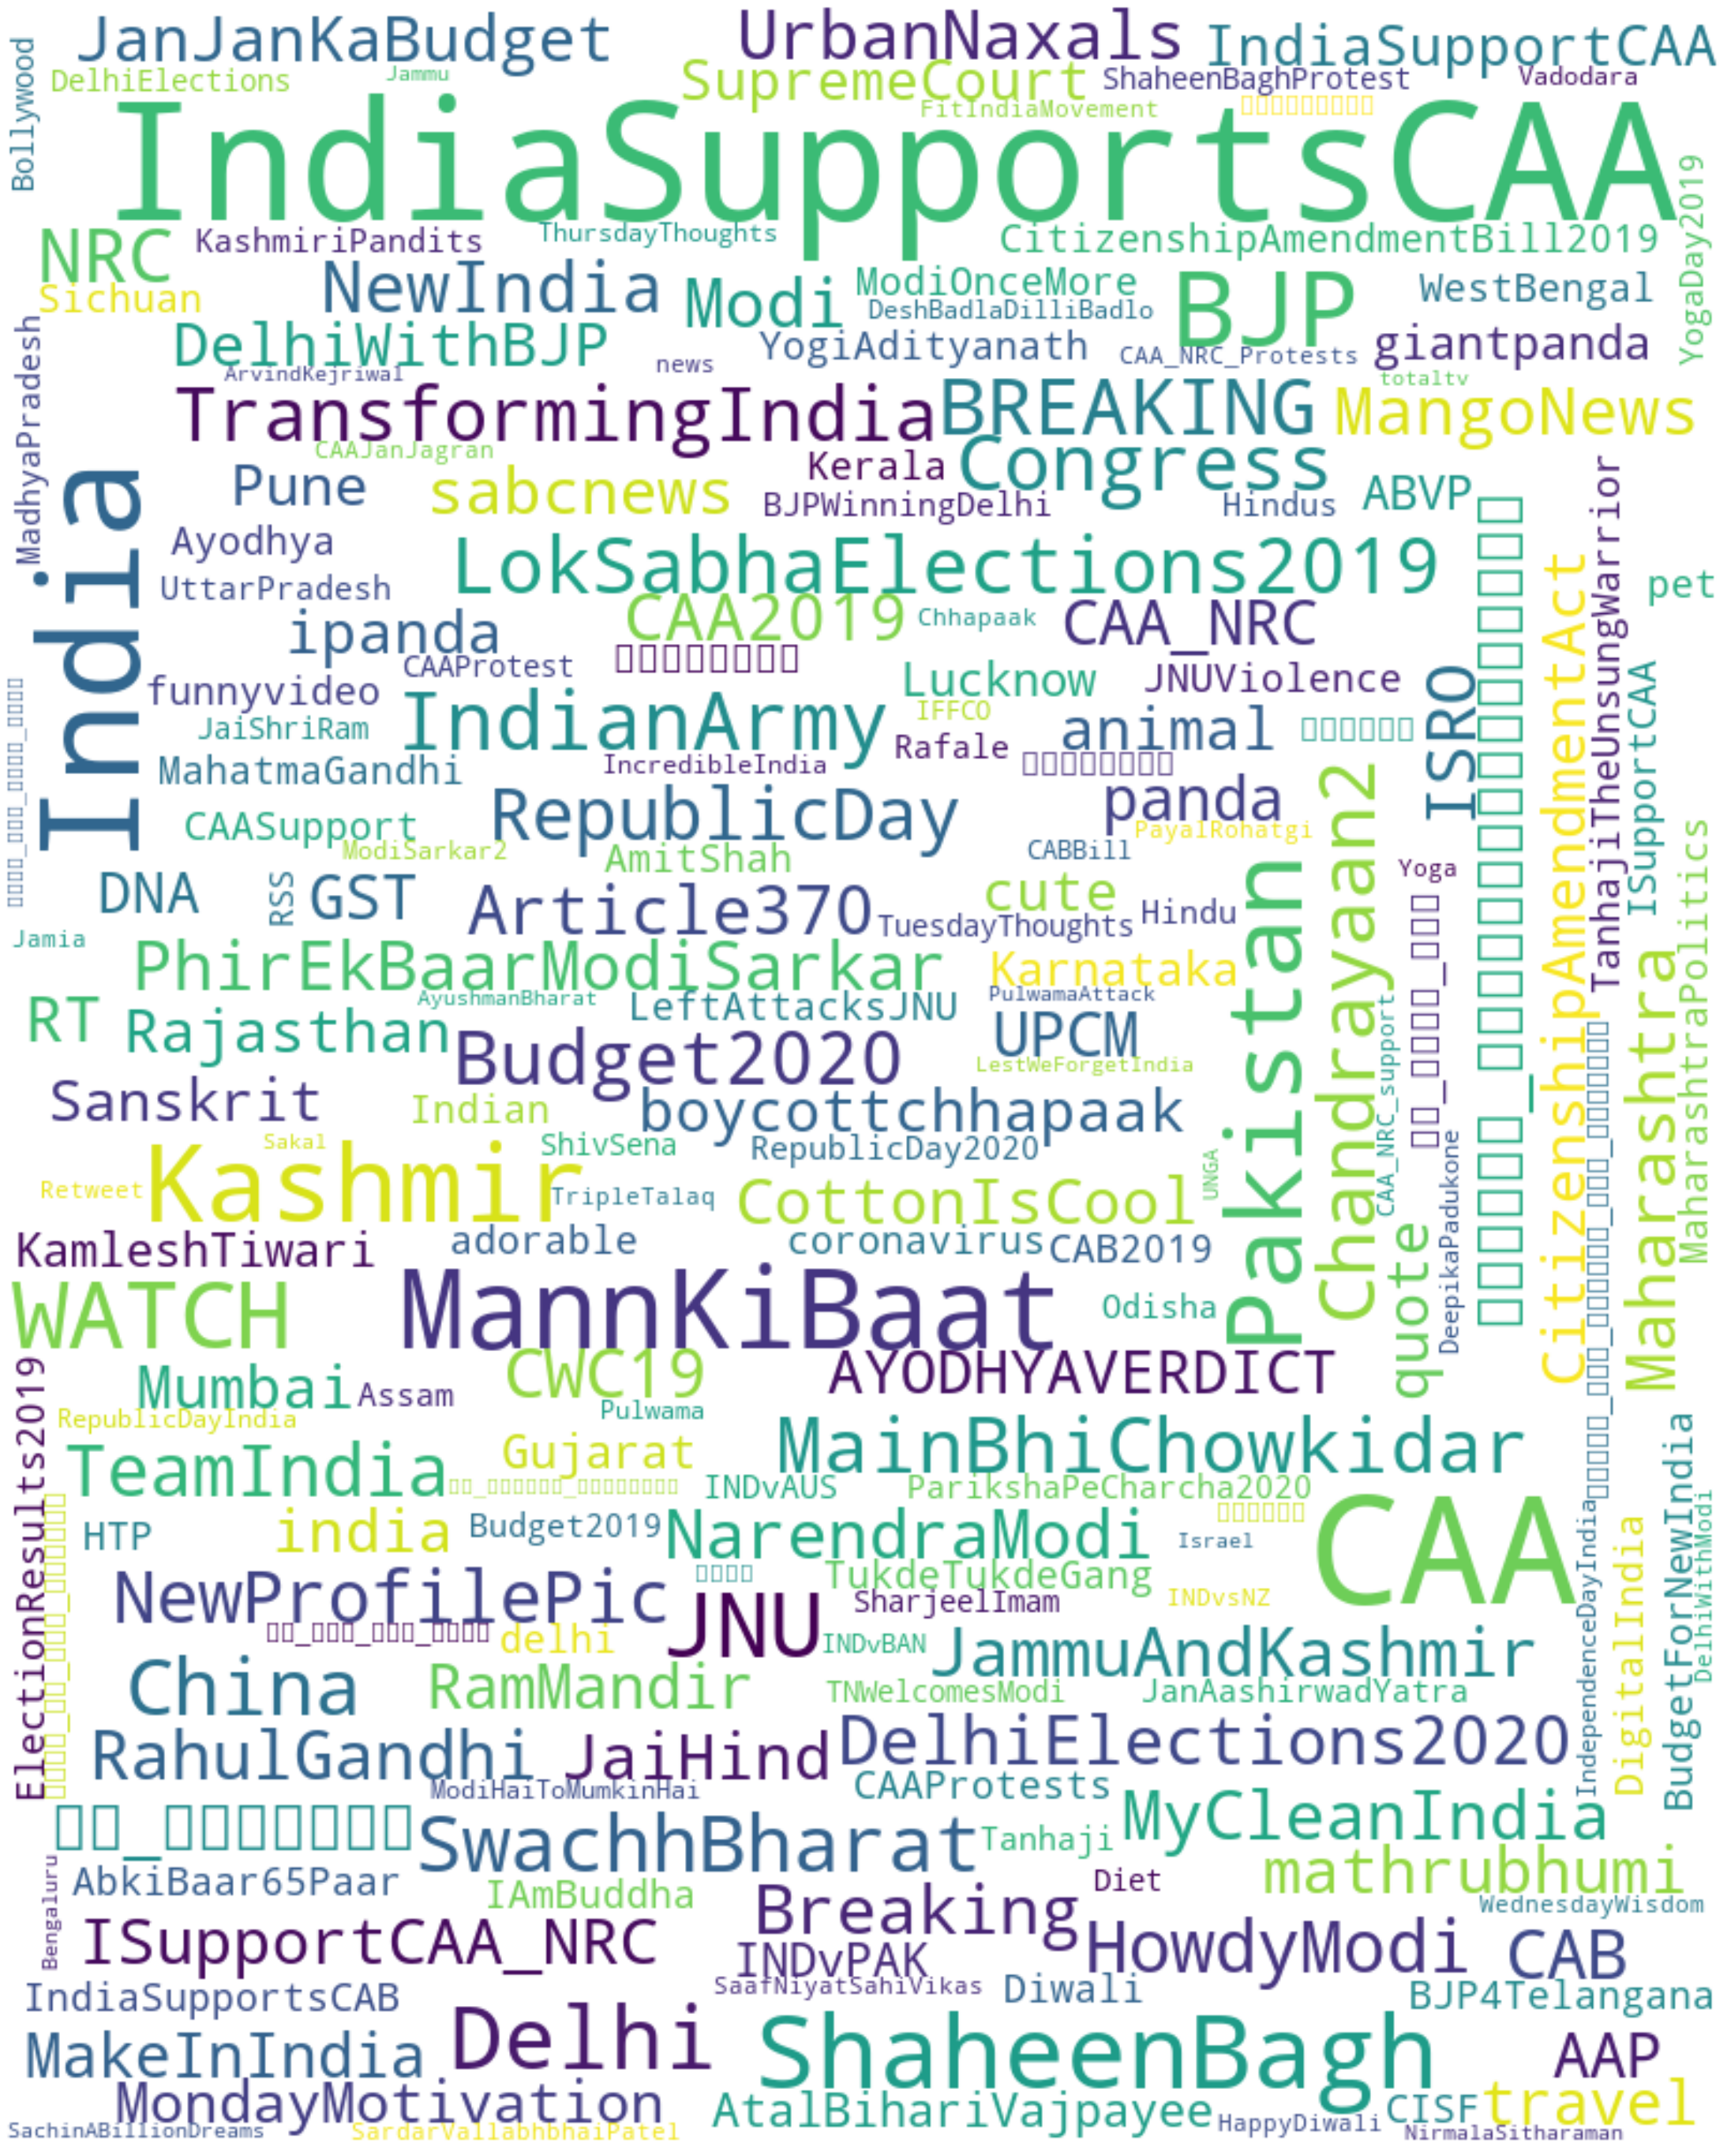

In [42]:
wc_dict = pd.DataFrame(hashtags_df[0],columns=["handle","freq"])
dct = wc_dict.set_index("handle").to_dict()['freq']
plot_word_cloud(dct)

Analyzing community from cluster 0 and the hashtags it becomes clear that this community is overwhelmingly ProBJP. The top hashtags here like IndiaSupportsCAA, MannKiBaat are overwhelmingly talked about by BJP leaders and its supporters. 

Similary we can see the hashtags used in cluster 1 using wordcloud below

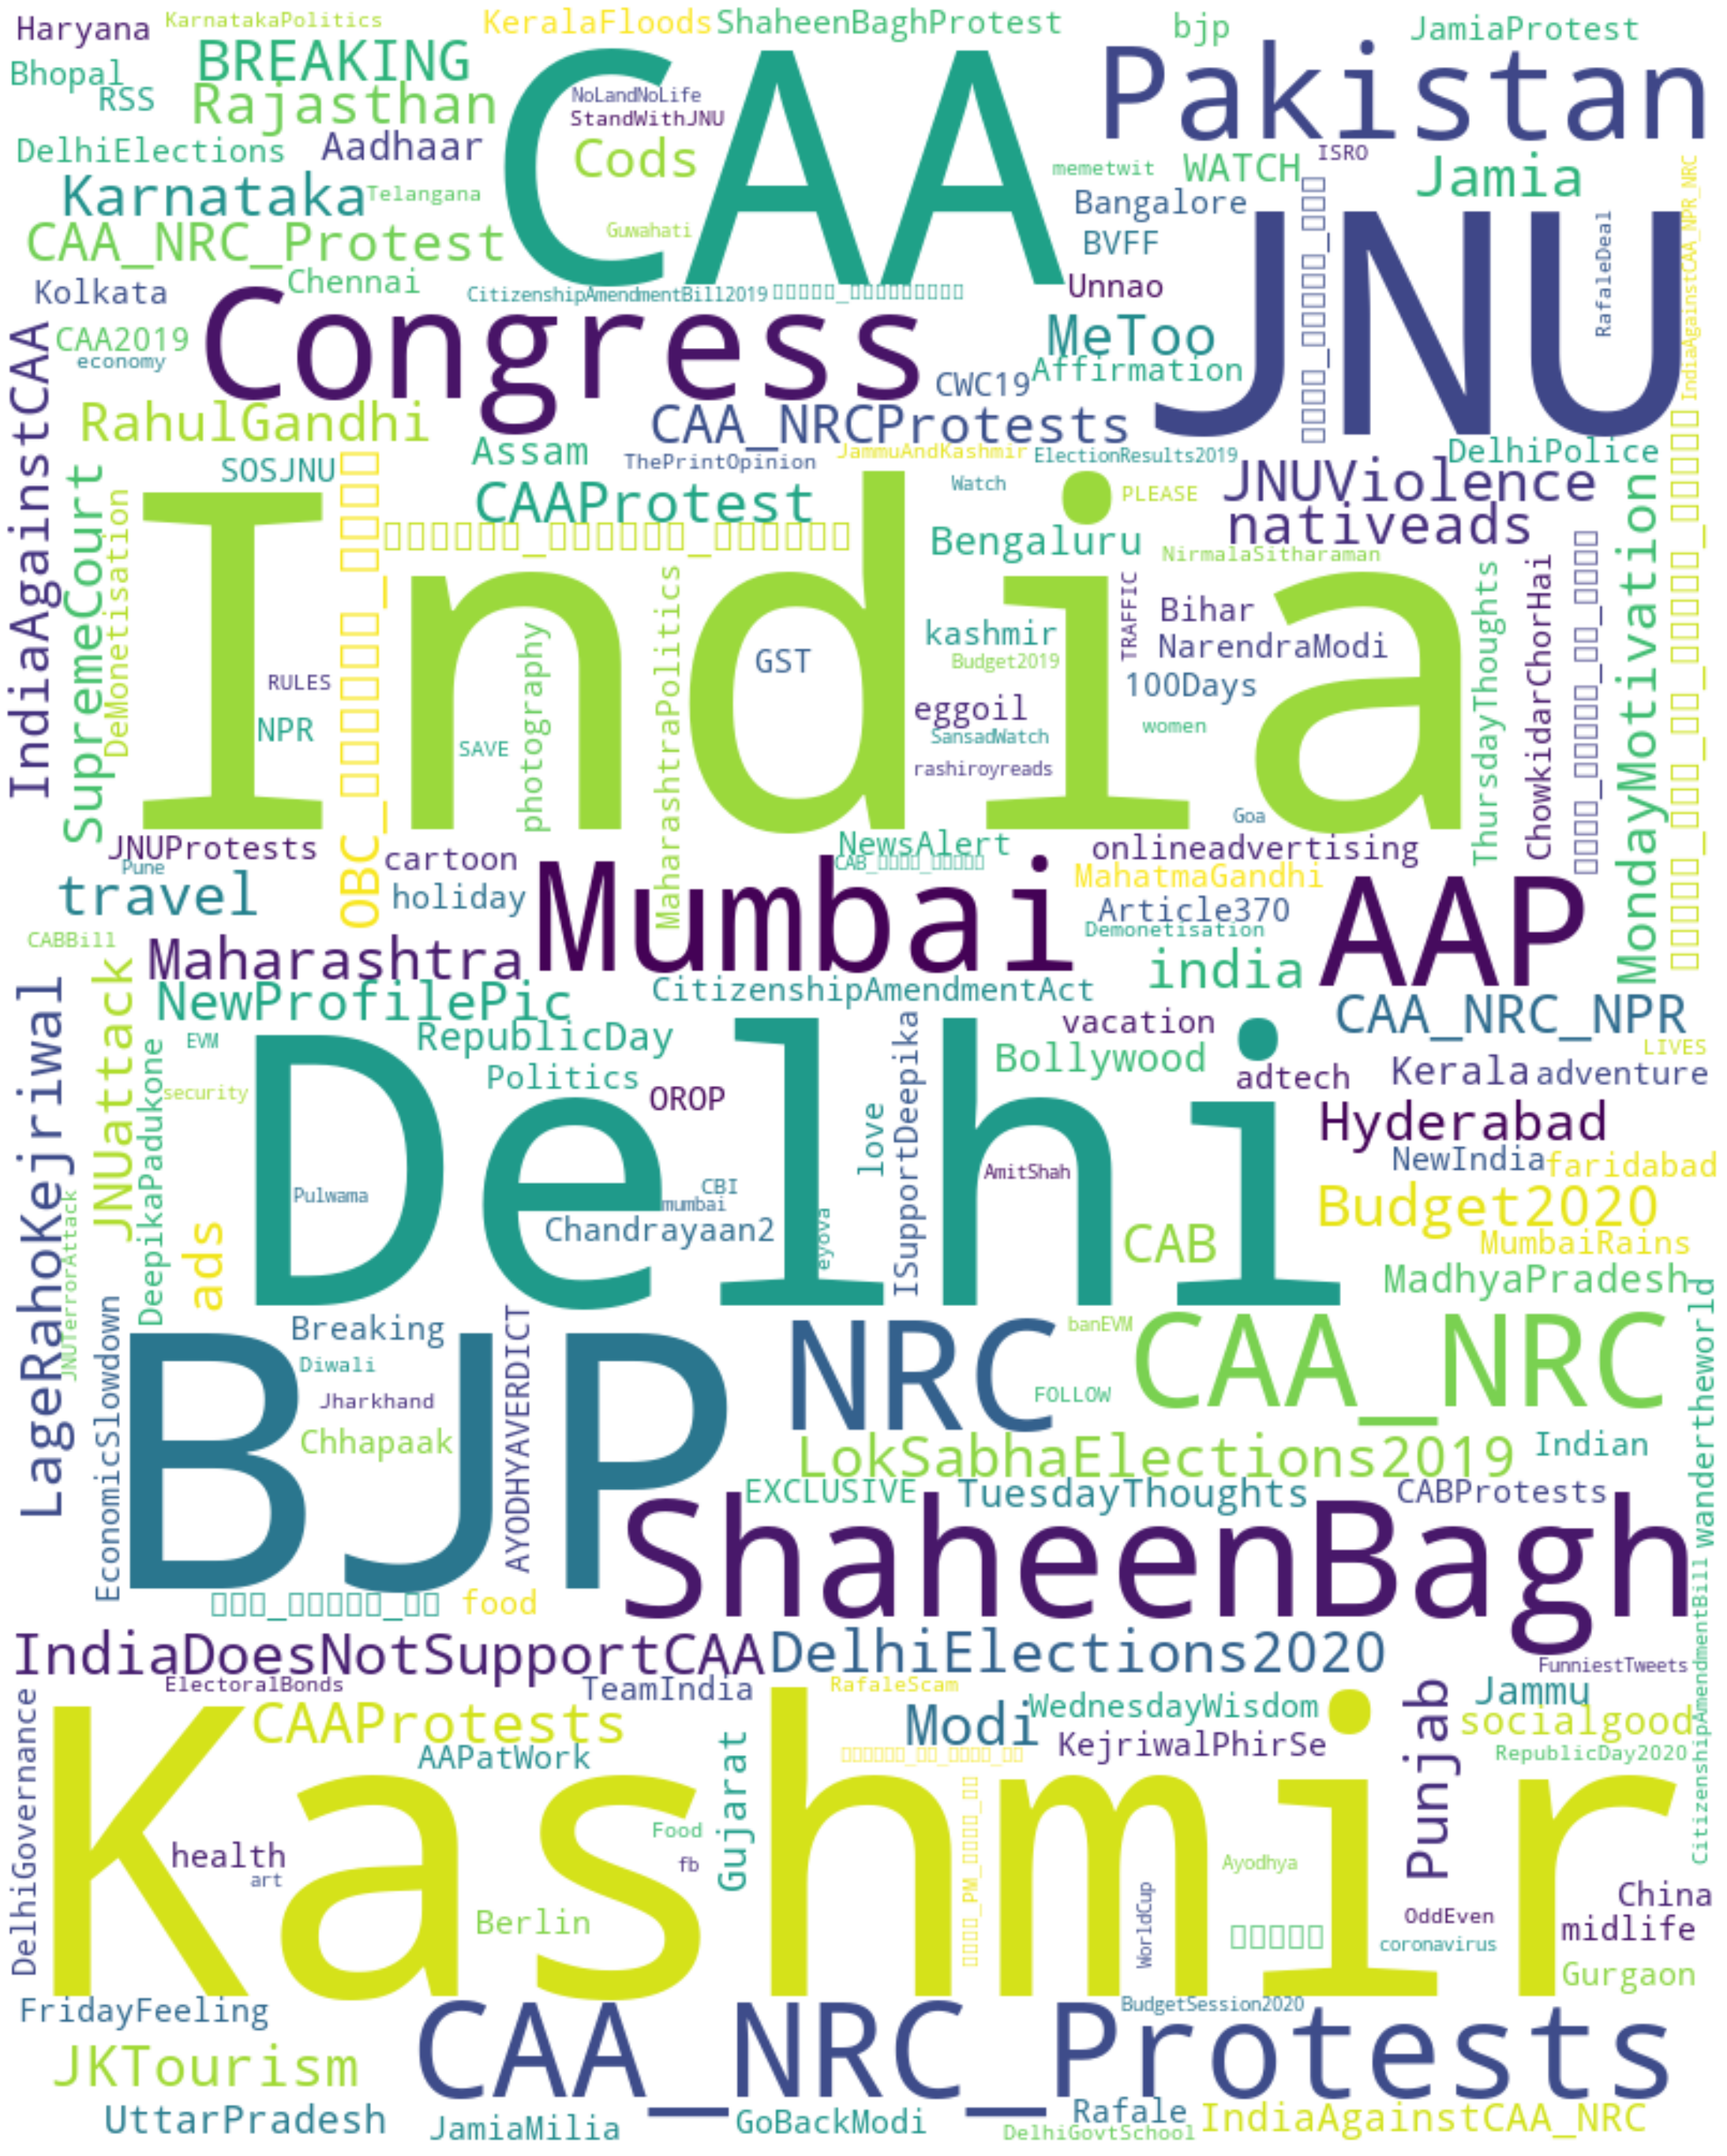

In [44]:
wc_dict = pd.DataFrame(hashtags_df[1],columns=["handle","freq"])
dct = wc_dict.set_index("handle").to_dict()['freq']
plot_word_cloud(dct)

This cluster again seems to support our assumption that this cluster is mostly AntiBJP and supports Congress and AAP. One more observation we can see is that this cluster talks more about BJP than Congress or AAP, can this mean this cluster is more AntiBJP than pro Congress or AAP? 

This cluster also seems very disorganised in the usage of hashtags. If you see the wordcloud for cluster 0 almost all the words are of similar size which indicates that they are more or less equal in frequency. Comparing that to this cluster we see there are more hashtags which have high frequency and some hashtags with low frequency. The important thing here is presence of multiple hashtags for the same event, this means that there is no concerted effort across cluster to trend certain hashtags. One interesting analysis that can be explored is identifying known BJP leaders and analyzing the response of the community when the leader tweets a particular handle.  

Next we analyse these clusters based on time

handle       mentions       retweets  cluster  importance  \
0           phumaoenix                          None        1         490   
1            JPFurlong                          None       91         395   
2           phumaoenix                          None        1         490   
3           phumaoenix                          None        1         490   
4            JPFurlong  globebusiness  globebusiness       91         395   
...                ...            ...            ...      ...         ...   
40141273  sven_giegold  FrantaNejedly           None       44         210   
40141274      BooMan23    tripgabriel           None       43         701   
40141275   ShekarTarak    HarshaNTR33           None       33         627   
40141276  _DaanishSyed   acbarrentine           None       43         286   
40141277       DonnyXL          Drake           None       34         196   

                            hashtags  
0                                     
1                                     
2                                     
3         BhagodaKejri,sheiladikshit  
4                                     
...                              ...  
40141273                              
40141274                              
40141275                              
40141276                              
40141277                              

[40141278 rows x 6 columns]

In [21]:
counter=1
for cluster_id in grouped_results.index.to_list():
    op_string = "|"+str(cluster_id) + " "
    int_str = ""
    for x in grouped_results[cluster_id][:5]:
        int_str+=str("|*")+" "+x[0]+str(x[1])+"|\n   "
    print(op_string+int_str)

|0 |* narendramodi450447|
   |* BJP4India166741|
   |* AmitShah152910|
   |* PMOIndia84858|
   |* ArvindKejriwal67572|
   
|1 |* ArvindKejriwal84260|
   |* RahulGandhi42230|
   |* narendramodi41864|
   |* INCIndia35295|
   |* AamAadmiParty34825|
   
|3 |* BleacherReport8885|
   |* YouTube7363|
   |* ArianaGrande5840|
   |* SportsCenter5708|
   |* espn4460|
   
|6 |* BeingSalmanKhan44445|
   |* ColorsTV43970|
   |* BiggBoss35304|
   |* justvoot26368|
   |* sidharth_shukla23287|
   
|8 |* BTS_twt7005|
   |* BloodDonorsIn5802|
   |* YouTube5564|
   |* PawanKalyan3833|
   |* NiallOfficial3730|
   
|14 |* realDonaldTrump33786|
   |* POTUS4746|
   |* FoxNews4160|
   |* YouTube4022|
   |* SpeakerPelosi3745|
   
|33 |* actorvijay13321|
   |* ikamalhaasan10615|
   |* rajinikanth7715|
   |* bishnoikuldeep5663|
   |* tarak99995251|
   
|34 |* Arsenal4730|
   |* ManUtd4483|
   |* LFC4016|
   |* sarkodie3705|
   |* YouTube1850|
   
|35 |* ImranKhanPTI10685|
   |* BBhuttoZardari6411|
   |* MaryamNSh

In [9]:
grouped_results[0][:5]

[('narendramodi', 450447),
 ('BJP4India', 166741),
 ('AmitShah', 152910),
 ('PMOIndia', 84858),
 ('ArvindKejriwal', 67572)]